# Analyzing microstimulation data  <br>

## Introduction
This notebook file can be used as a guideline for analyzing data concerning the MTL-dependent microstimulation detection task as described in Doron et al. (2020). It is meant to show students or newly interested the step-by-step process from raw data to beautiful graphs. Within this, script the Mouse_Data dataclass and functions from the helpers.py will be explained and used for data-analysis. The analysis will be performed on the data files that are contained within the sibling-folder: 'data'. 
<br><br>
### Importing functions
We will start by importing the necessary functions. In order to prevent import or modulenotfound errors it is adviced to mimic the file structure from GitHub. This means that this: 'analysis.ipynb' file should be in the same folder as 'Mouse_Data.py'& 'helpers.py'.

In [1]:
# First we will have to import the dataclass we're using to hold our data, as well as, the helper functions that we'll need.
from Mouse_Data import Mouse_Data
from helpers import *

# We will also import some additional functions from commonly used packages for convenience and plotting.
import os
import matplotlib.pyplot as plt

### Importing your data
Next we'll import the data we will be analyzing. The example data can be found in the GitHub repository witin the 'data' folder. It is advisable to first do a test run with the example data and make sure you understand the process, before proceding with your own data.
The code requires the path to the data folder which in the case of the example data should look something like this: <code>C:Users/username/coding_projects/microstimulation/data</code><br><br>
The content of the datafolder is structured in the following way:<br>
- ID0
    - session0
    - session1
- ID1
    - session0<br>
    
    
Within this datafolder there are subfolders *ID0, ID1* that refer individual animals and their sessions *session0, session1*. Within the folder of each session there should be .txt files that contain the extracted SPIKE2 data. After you have provided the path and checked if it contains the correct data we will load in the data using the Mouse_Data dataclass. 


In [2]:
# Select the path to your data files, replace '\' with '/' if you copied your path. 
# Also make sure it ends with '/' so that it's recognized as a folder.
path = 'C:/Users/miksc/OneDrive/coding_projects/Microstimulation/data/'
datafiles = os.listdir(path)
print(f'The path you provided contains the following files: \n{datafiles}')

The path you provided contains the following files: 
['ID0', 'ID1', 'ID2', 'ID3']


In [3]:
# Load the datafiles into Python using Mouse_Data
mouse_list = []
for file in datafiles:
    path_to_data = path+file
    mouse = Mouse_Data(path_to_data)
    mouse_list.append(mouse)
print(mouse_list)

[<Mouse_Data.Mouse_Data object at 0x000002691A42EC80>, <Mouse_Data.Mouse_Data object at 0x00000269170D6B30>, <Mouse_Data.Mouse_Data object at 0x000002691740B3A0>, <Mouse_Data.Mouse_Data object at 0x000002691A42ECB0>]


### The Mouse_Data Class
Congratulations you've now succesfully imported the SPIKE2 data into the Mouse_Data class. The *mouse_list* holds four of them. Each Mouse_Data class contains four interesting attributes: id, sessions, all_data and full_data. To call these attributes type  <code>Mouse_Data.id, Mouse_Data.sessions, Mouse_Data.all_data or Mouse_Data.full_data</code> 
The attributes hold the following data:
1. **id** | This is simply the name of the mouse, in real data this would look something like: SNA-123456. 
2. **sessions** | This is the date of the experimental sessions and should look like 01_05_2020
3. **all_data** | A dictionary of pd.DataFrames with: *stim_t* (stimulus timestamp), *response_t* (response timestamp), *intensity* (current in uA) and *succes* (detected or not detected). Each key holds the data of an experimental session.
4. **full_data** | A concatenated pd.DataFrame of *all_data* from every session <br />

<br>
Below I show you the data within these attributes.

In [4]:
# Lets select a single mouse and show it's ID, the date of the first session and the corresponding data
mouse0 = mouse_list[0]
session0 = mouse0.sessions[0]
print(f'ID = {mouse0.id}, first session date = {session0}')

# In order to access the data of a single session you must provide the all_data dictionary with the session date
print(f'mouse0.all_data is a dictionary of pd.DataFrames with keys: {mouse0.all_data.keys()}')
display(mouse0.all_data[session0])

ID = ID0, first session date = 16_02_2022
mouse0.all_data is a dictionary of pd.DataFrames with keys: dict_keys(['16_02_2022', '17_02_2022', '18_02_2022', '19_02_2022'])


,stim_t,response_t,intensity,succes
0,21.6550,0.48098,160.0,True
1,38.0901,0.56622,160.0,True
2,43.8422,0.45297,160.0,True
3,47.9083,0.46665,160.0,True
4,55.5276,0.46318,160.0,True
...,...,...,...,...
352,2600.1438,-0.10000,70.0,False
353,2610.1906,-0.10000,70.0,False
354,2613.6102,0.44966,70.0,True
355,2616.2440,-0.10000,70.0,False


### Visualizing data, the decrease in threshold
Within the microstimulation detection paradigm the mouse is trained to detect an ever-decreasing electrical stimulus. Training usually takes 2-4 days, during which the threshold decreases gradually. In order to visualize the decrease in threshold over consequtive days (experimental sessions) we plot the lowest succesfully detected stimulus intensity (threshold) for each day until expert performance (20uA). <b>

Data: [[160, 40.0, 40.0, 30.0, 18.0], [160, 70.0, 10.0, 10.0, 10.0], [160, 120.0, 30.0, 16.0, 16.0], [160, 100.0, 16.0, 16.0, 16.0]]


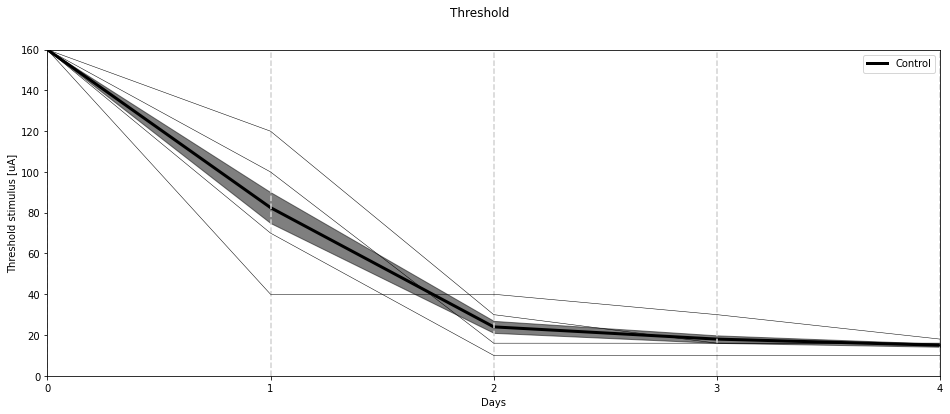

In [9]:
'''Show (average) threshold for each experimental session'''
# Get the threshold list for each animal
min_score = 0.8 # This is the minimal fraction of correct trials.
threshold_data = get_threshold_data(mouse_list, min_score) # Calculate the daily threshold for all mice in mouse_list

def plot_daily_threshold(threshold_data, max_sessions=5):
    ''' Plots the lowest detected stimulus intensity (threhsold) for each experimental session.
    
        INPUT:
            threshold_data(list): list of lists containing the thresholds for each mouse, as 
                                  generated by get_threshold_data()
            max_sessions(int): maximum number of days the avg and std is calculated over
        OUTPUT:
            plot(matplotlib.pyplot): a plot of the daily threshold 
    '''
    # First get the averages and std for plotting
    n = len(threshold_data)
    avg, std = get_avg_std_threshold(threshold_data, max_sessions)
    
    # Set figure basics 
    fig = plt.figure(figsize=(16,6))
    fig.patch.set_facecolor('white')
    x = np.arange(0, max_sessions, 1)
    
    # First plot the average lines
    plt.plot(x, avg, linewidth=3, color='black')
    plt.legend(['Control'])
    
    # Create vertical lines for each day
    for i in range(max_sessions):
        plt.axvline(i, c='lightgray', linestyle='--')
        
    # Individual lines for testing
    for data in threshold_data:
        plt.plot(x, data, color='black', linewidth=0.5)
    
    # Add SEM
    sem = np.array(std)/n
    y_min = np.subtract(avg, sem)
    y_max = np.add(avg, sem)
    plt.fill_between(x, y_min, y_max, alpha=0.5, color='black')
    
    # Plot adjustments
    plt.xlim([0.5, 4])
    plt.ylabel('Threshold stimulus [uA]')
    plt.xlabel('Days')
    plt.xticks([0,1,2,3,4])
    plt.xlim([0, 4])
    plt.ylim([0, 160])
    plt.suptitle('Threshold')
    plt.show()
    return

print(f'Data: {threshold_data}')
plot_daily_threshold(threshold_data)

### Visualizing data, threshold per trial
As we can see within the figure above the stimulation threshold decreases steadily during the first experimental session to an average of 90uA and subsequently to 30uA on the second session. However, this daily measurement doesn't give us much information on the progression during the session itsself. Therefore, we should plot the stimulus intensity for each trial. This plot also meant to show the performance of each stimulus block and therefore blocks all stimuli into blocks of n. Moreover, if you tell the function to extend it will extend the stimuli of all mice to contain the same number of stimuli as the maximum performed by one mouse.

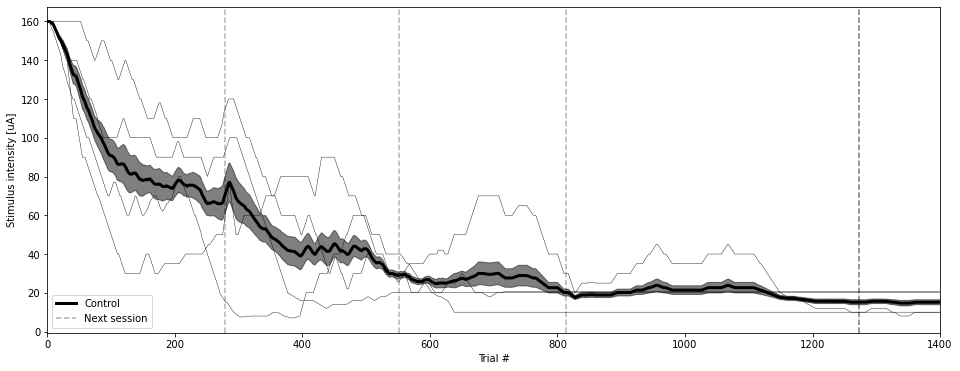

In [20]:
'''Show the (average) intensity of each successive stimulus'''

def plot_intensity_trials(mouse_data, blocksize=10, extend=False):
    ''' Iterate through trials, get the average intensity of the last 10 trials as well as the performance score TODO
        then plot the progression of blocked threshold over trials.
        
        INPUT:
            mouse_data(list): list of MouseData classes  
        OUTPUT:
            plot(matplotlib.pyplot): a plot showing the stimulus intensity over trials
    '''
    # Extract some data
    n = len(mouse_data)

    # First generate a list that will contain lists of blocked scores
    blocked_list = []
    for mouse in mouse_data:
        # Cut all trials into blocks and calulate the average intensity of this block
        raw_intensity = mouse.full_data['intensity'].to_numpy()
        blocked_intensity = get_blocked_score(raw_intensity, blocksize)
        blocked_list.append(blocked_intensity)        
        
    if extend:
        blocked_list = extend_lists(blocked_list)
        
    # Calculate average, std and sem of the blocked intensity
    avg, std = get_average_cum_score(blocked_list)
    sem = np.array(std)/n
    
    # How many trials we plotting
    max_trials = len(avg)
    x = np.arange(0, max_trials, 1)
    
    # How many trials did the average session contain
    len_df = get_average_session_len(mouse_data)

    # Plot
    # Set figure basics 
    fig = plt.figure(figsize=(16,6))
    fig.patch.set_facecolor('white')    
    
    # Plot the average 
    avg_line = plt.plot(x, avg, color='black', linewidth=3)
    
    # Add average trial length lines
    i_lines = len_df.loc[:, 'sum_avg']
    [plt.axvline(line, color='black', linestyle='--', alpha=0.3, label='Next session') for line in i_lines]
    
    # Plot individual lines
    [plt.plot(individual, color='black', linewidth=0.4) for individual in blocked_list]

    # Add SEM  NOTE: sem changes a lot when a mouse drops off e.g. when all trials have been conducted
    y_min = np.subtract(avg, sem)
    y_max = np.add(avg, sem)
    plt.fill_between(x, y_min, y_max, alpha=0.5, color='black')
    # Adjust plot
    plt.xlim([0, 1400])
    plt.ylabel('Stimulus intensity [uA]')
    plt.xlabel('Trial #')
    plt.legend(['Control', 'Next session'])
    plt.show()
    return

plot_intensity_trials(mouse_list, extend=True)